<a href="https://colab.research.google.com/github/yaroslavpod/osmz/blob/master/Copy%22ds4_04_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithms for Big Data - Exercise 4
This lecture is focused in more detailed understanding of the Convolution neural networks. 

The visualization and the response of the CNN layers will be intestigated and a proper.

We will use the MNIST dataset but other may be used as well.


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_04.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_04.ipynb)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
import scipy

tf.version.VERSION

'2.3.0'

In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28,28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

In [ ]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

In [ ]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = [str(x) for x in range(10)]
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_count = len(class_names)
print('Class count:', class_count, class_names)


11493376/11490434 [==============================] - 0s 0us/step
Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#### Show example images of the dataset

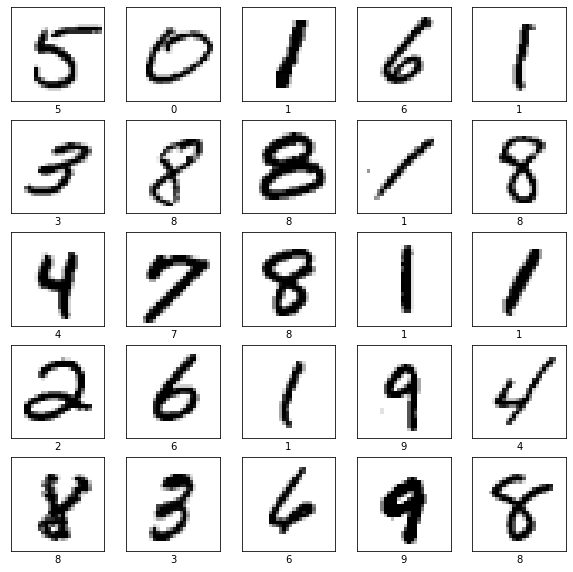

In [ ]:
show_example(train_x, train_y, class_names)

### Create a well defined model 

The model is able achieve more the 99% precision on the validation as well as testing sets.

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='softmax'),
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          9232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

#### Fit the model on the train data.
Lets train the model on the training data and find the best model using the EarlyStopping callback to find the best model avaialble and achievable.

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3775 - accuracy: 0.8789 - val_loss: 0.0963 - val_accuracy: 0.9724
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1184 - accuracy: 0.9672 - val_loss: 0.0605 - val_accuracy: 0.9830
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0853 - accuracy: 0.9774 - val_loss: 0.0575 - val_accuracy: 0.9848
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0713 - accuracy: 0.9810 - val_loss: 0.0508 - val_accuracy: 0.9868
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0610 - accuracy: 0.9833 - val_loss: 0.0614 - val_accuracy: 0.9830
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0516 - accuracy: 0.9864 - val_loss: 0.0424 - val_accuracy: 0.9887
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0434 - accuracy: 0.9883 - val_loss: 0.0456 - val_accuracy:

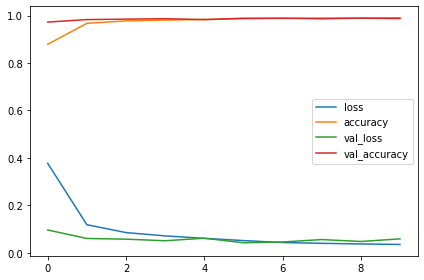

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

# batch_size = 32
# epochs = 50

batch_size = 32
epochs = 10
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[es], epochs=epochs, batch_size=batch_size)

show_history(history)

test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Visualize the layers
Lest see what the network was able to learn from the train data. For that, we need to prepare a new model and see the ouputs of the layers.

In [ ]:
# get the outputs form all layers in the model
layer_outputs = [layer.output for layer in model.layers]
# create the model that has single input and as an output all the outputs from the layers. 
# Because the layers are connected then the output from first layer is propagated into second layer and the output is computed o it.
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

# get all the outputs from the model for 10-th input
activations = activation_model.predict(train_x[10].reshape(1,28,28,1))
 
# this functions shows the output from each filters
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

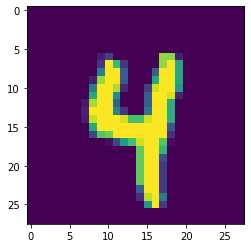

In [ ]:
# show the input image
plt.imshow(train_x[10][:,:,0]);

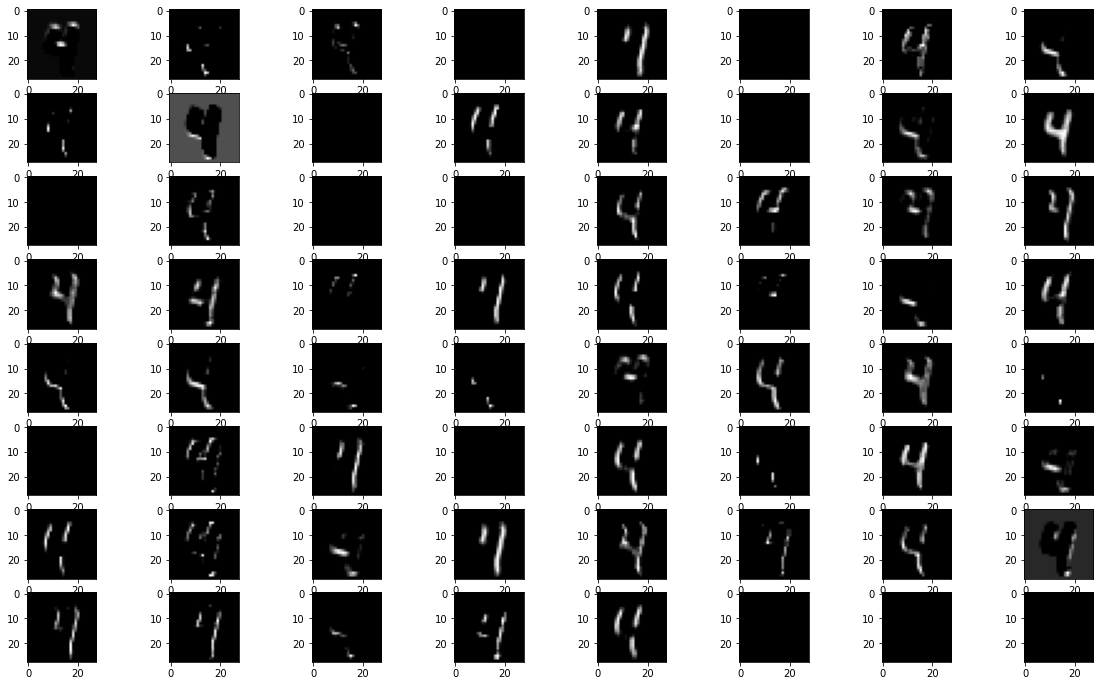

In [ ]:
# show the output from the first layer - CNN2D
display_activation(activations, 8, 8, 0)

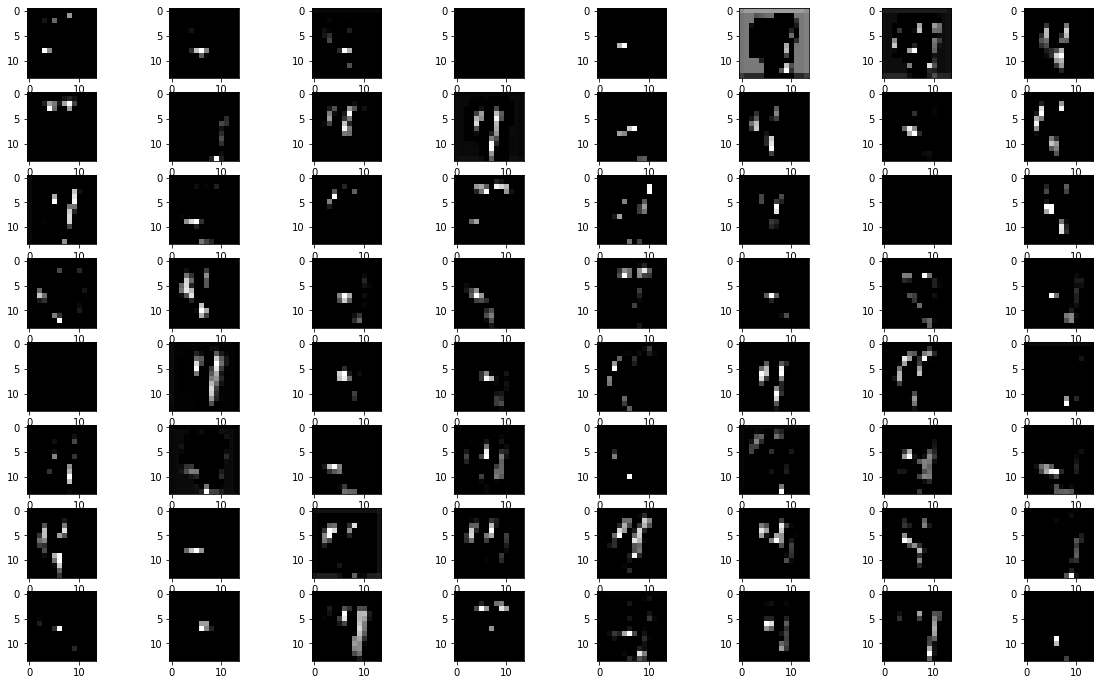

In [ ]:
# show the second convolution layer
display_activation(activations, 8, 8, 2)

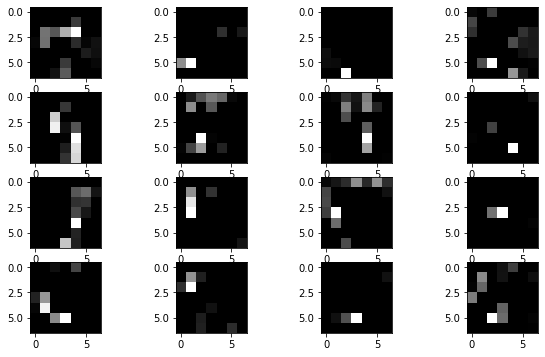

In [ ]:
# show the third activation layer
display_activation(activations, 4, 4, 4)

## The weights of each layer
The weight can be extracted from layer as a tuple of weights and biasses

In [ ]:
filters, biases = model.layers[0].get_weights()
print(filters.shape, biases.shape)

(3, 3, 1, 64) (64,)


In [ ]:
#### The weights may be normalized in to 0-1 interval

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

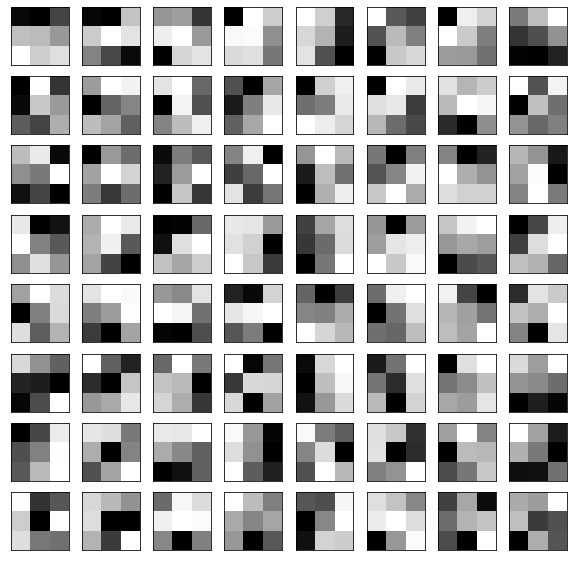

In [ ]:
plt.figure(figsize=(10,10))

# plot first few filters
n_filters = 64
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    # specify subplot and turn of axis
    ax = plt.subplot(8, 8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
  
# show the figure
plt.show()

## Autoencoder
The autoencoder is a special type of neural network that is able to learn without the classes just from the input data. It is equivalent to the feature extraction from the data.

It's worth a mention that we are using binary crossentropy loss, thus we compare images on per-pixel basis.
- You can view [this link](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) for more information about Bin. CE

In [ ]:
autoencoder = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    # a 128 values of the minimized knowledge / features
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    
    keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

autoencoder.summary()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           2312      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 8)          

### Fit the model
The model may be fitted as much as possible, this model converges but slowly.

Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1834 - accuracy: 0.7976 - val_loss: 0.1303 - val_accuracy: 0.8052
Epoch 2/10
375/375 [==============================] - 4s 9ms/step - loss: 0.1199 - accuracy: 0.8086 - val_loss: 0.1126 - val_accuracy: 0.8093
Epoch 3/10
375/375 [==============================] - 4s 9ms/step - loss: 0.1083 - accuracy: 0.8109 - val_loss: 0.1045 - val_accuracy: 0.8117
Epoch 4/10
375/375 [==============================] - 4s 9ms/step - loss: 0.1027 - accuracy: 0.8118 - val_loss: 0.1010 - val_accuracy: 0.8118
Epoch 5/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0991 - accuracy: 0.8124 - val_loss: 0.0976 - val_accuracy: 0.8131
Epoch 6/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0966 - accuracy: 0.8127 - val_loss: 0.0958 - val_accuracy: 0.8135
Epoch 7/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0946 - accuracy: 0.8130 - val_loss: 0.0936 - val_accuracy: 0.8133
Epoch

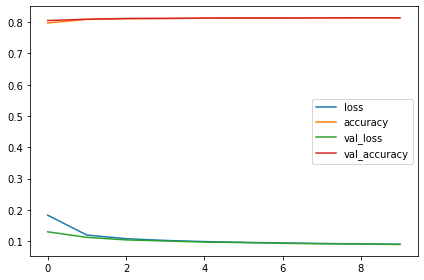

In [ ]:
history = autoencoder.fit(train_x, train_x, validation_data=(valid_x, valid_x), epochs=10, batch_size=128)

show_history(history)

### Generate original and reconstructed images
The autoencoder fits on the original data on input as well as on output, therefore it is possible to generate reconstructed images.

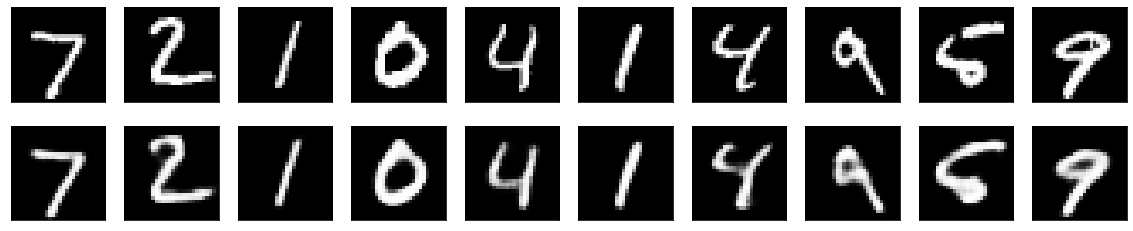

In [ ]:
predicted = autoencoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Vizualize the encoded vectors
The vectors that are generated by the encoder may be vizualized.

In [ ]:
encoder = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
])

# encoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder.set_weights(autoencoder.get_weights()[:6])

for layer in encoder.layers:
  layer.trainable = False

encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 8)           2312      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
Total params: 21,416
Trainable params: 0
Non-trainable params: 21,416
__________________________________________________

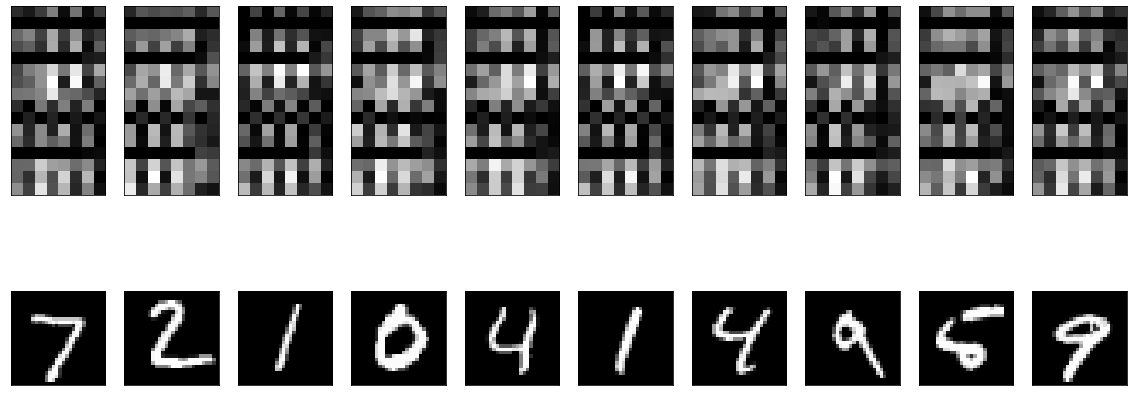

In [ ]:
encoded = encoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(encoded[i].reshape(8, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(test_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Is the encoder-based classifier better than the previous one above?
The encoder generated using the autoencoder principle generate a compressed representation of the input. The inner vector with 128 values is much smaller and the goal of the autoencoder is different than from the classifier, therefore the generated representation is usually better using the classifier directly.
Some variants of encoder are able to generate better representation - a sparse autoencoders that generate sparse representation for example.

### Is it possible to control how sparse our representation will be? If it's possible, what method would you use? [API](https://keras.io/api/layers/regularizers/)

### Why is it usually better to use classifier directly and not train encoder for feature extraction first and then put classification layers on top of it? 

In [ ]:

encoder.add(keras.layers.Flatten())
encoder.add(keras.layers.Dense(64, activation='relu'))
encoder.add(keras.layers.Dropout(0.25))
encoder.add(keras.layers.Dense(32, activation='relu'))
encoder.add(keras.layers.Dropout(0.25))
encoder.add(keras.layers.Dense(10, activation='softmax'))




In [ ]:
encoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 8)           2312      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 1.2270 - accuracy: 0.5779 - val_loss: 0.4558 - val_accuracy: 0.8677
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6557 - accuracy: 0.7776 - val_loss: 0.3186 - val_accuracy: 0.9035
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5475 - accuracy: 0.8186 - val_loss: 0.2820 - val_accuracy: 0.9118
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4812 - accuracy: 0.8434 - val_loss: 0.2616 - val_accuracy: 0.9217
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4418 - accuracy: 0.8576 - val_loss: 0.2306 - val_accuracy: 0.9259
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4172 - accuracy: 0.8668 - val_loss: 0.1999 - val_accuracy: 0.9398
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3984 - accuracy: 0.8745 - val_loss: 0.1824 - val_accuracy:

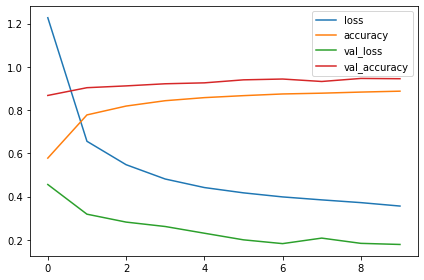

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

history = encoder.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks = [es], epochs=10)

show_history(history)

test_loss, test_acc = encoder.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Outlier analysis
Let use the autoencoder as an outlier analyzer. 

First, prepare the testing set. then create a outlier data and compare the prediction error on the both.

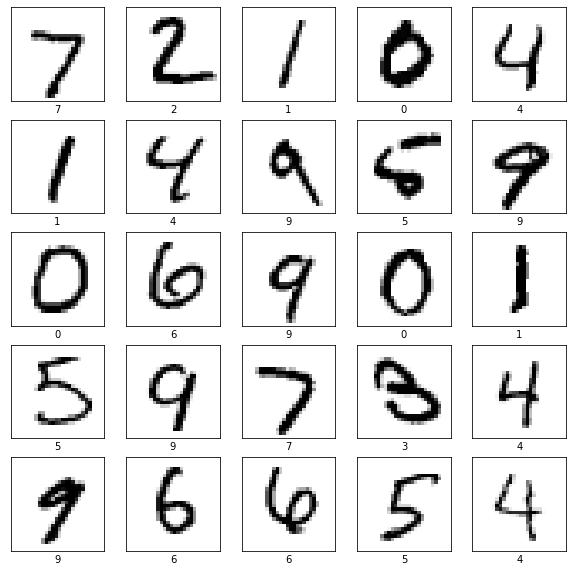

In [ ]:
sample_x = test_x[:25]
sample_y = test_y[:25]

show_example(sample_x, sample_y, class_names)

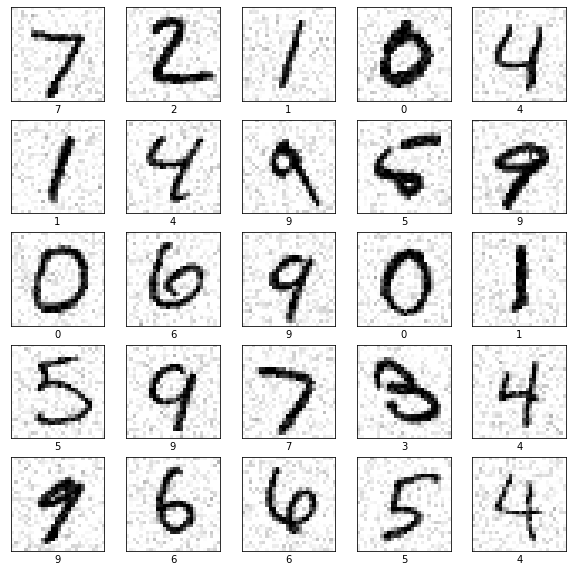

In [ ]:
modified_x = np.clip(sample_x + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=sample_x.shape), 0., 1.) 
modified_y = sample_y
show_example(modified_x, modified_y, class_names)

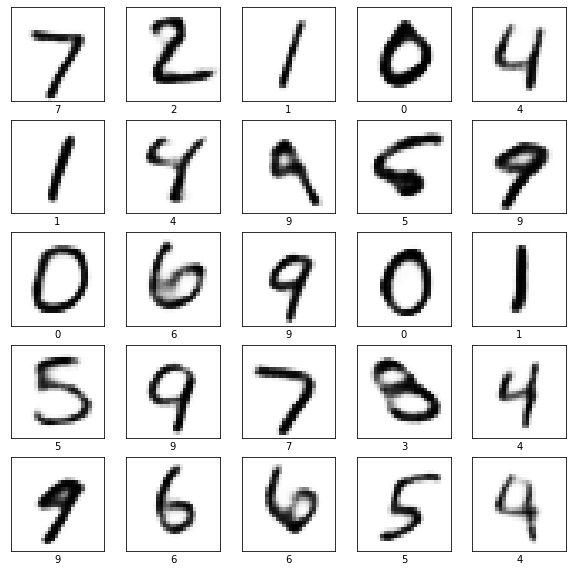

In [ ]:
sample_predicted = autoencoder.predict(sample_x)
show_example(sample_predicted, sample_y, class_names)

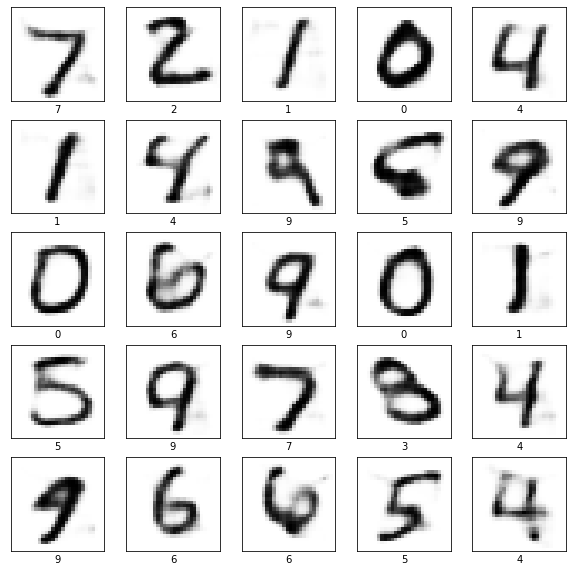

In [ ]:
modified_pred = autoencoder.predict(modified_x)
show_example(modified_pred, modified_y, class_names)

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
# np.linalg.norm -> Frobenius norm ~ root of squared errors

sample_norms = [np.linalg.norm(sample_x[i].reshape(28,28)- sample_predicted[i].reshape(28,28)) for i in range(len(sample_x))]
modified_norms = [np.linalg.norm(modified_x[i].reshape(28,28)- modified_pred[i].reshape(28,28)) for i in range(len(sample_x))]

sample_mean, sample_std = np.mean(sample_norms), np.std(sample_norms)
modified_mean, modified_std = np.mean(modified_norms), np.std(modified_norms)

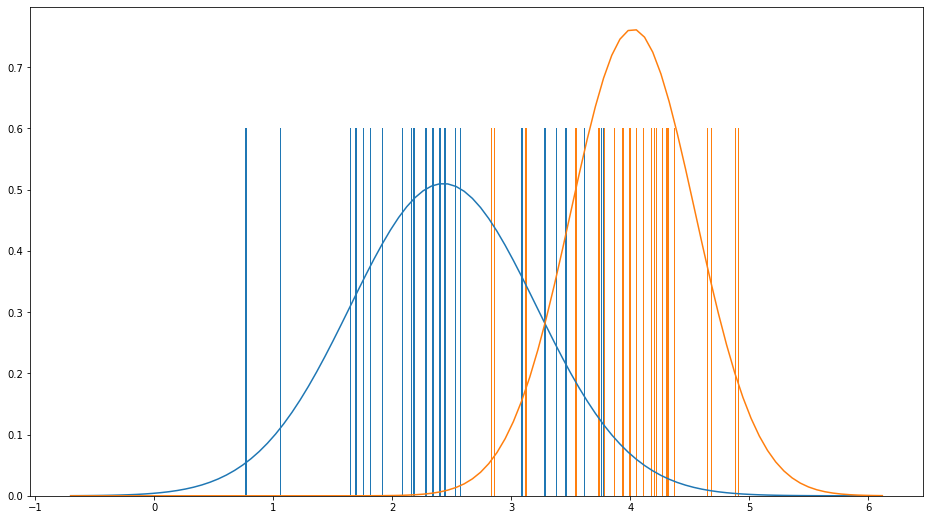

In [ ]:
plt.figure(figsize=(16,9))
xmin = np.min([sample_mean-4*sample_std, modified_mean-4*modified_std])
xmax = np.max([sample_mean+4*sample_std, modified_mean+4*modified_std])

x = np.linspace(xmin, xmax, 100)

y = scipy.stats.norm.pdf(x,sample_mean,sample_std)

plt.plot(x,y)

y = scipy.stats.norm.pdf(x,modified_mean,modified_std)

plt.plot(x,y)

plt.bar(x=sample_norms, height=[0.6 for x in sample_norms], width=0.01)
plt.bar(x=modified_norms, height=[0.6 for x in sample_norms], width=0.01)
plt.show()

## Denoising-autoencoder
The denoising autoencoder is a autoencoder that will learn how to remove random noise from the images. 

First, noisy images have to be generated. 

Then the autoencoder need to be created and trained. 

Then denosed images may be reconstructed.

## Tasks for Lecture / Exercise
1. Implement the autoencoder that do something usefull like denoising, implement it on the data defined above.
2. The Keras contains stored models that may be used for classification. The pretrained models may be used effectivelly to classify data, e.g. images, using the state of the art models. Try to investigate the architecture of the stored models and use the for classification of sample data downloaded from the internet.
  1. Try VGG16 model and investigrate its architecture.
  2. Try ResNet model architecture.
- See [Keras Functional API](https://keras.io/guides/functional_api/)

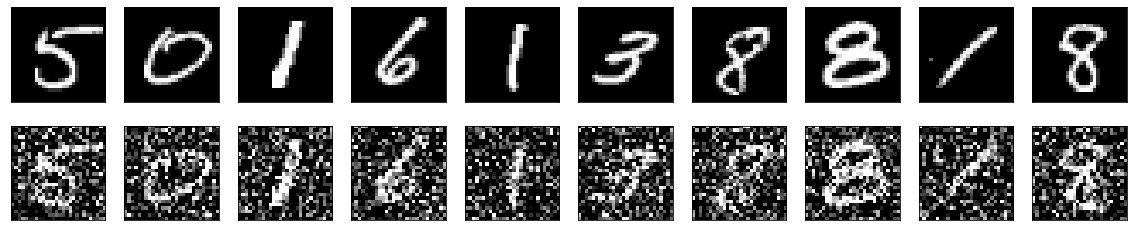

In [ ]:
#@title Текст назви за умовчанням
noise_factor = 0.75
noisy_train_x = np.clip(train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape), 0., 1.)
noisy_valid_x = np.clip(valid_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_x.shape), 0., 1.)
noisy_test_x = np.clip(test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape), 0., 1.) 


n = 10
plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(noisy_train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
from keras.callbacks import TensorBoard
autoencoder.fit(noisy_train_x, train_x,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(noisy_test_x, test_x),
                callbacks=[TensorBoard(histogram_freq=0, write_graph=False)])

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.2126 - val_loss: 0.1601
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1552 - val_loss: 0.1491
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1477 - val_loss: 0.1438
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1434 - val_loss: 0.1403
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1403 - val_loss: 0.1384
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1381 - val_loss: 0.1361
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1365 - val_loss: 0.1344
Epoch 8/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1351 - val_loss: 0.1338
Epoch 9/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1341 - val_loss: 0.1323
Epoch 10/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1329 - val_loss: 0.1314

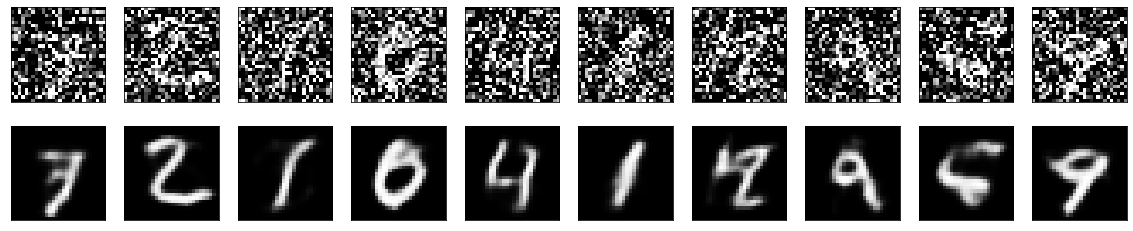

In [ ]:
decoded_img = autoencoder.predict(noisy_test_x)
n = 10
plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(noisy_test_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(decoded_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
import cv2

In [ ]:
def grayscale_to_rgb(images, channel_axis=-1):
    # images= keras.backend.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= keras.backend.tile(images, tiling)
    return images

In [ ]:
size = 32

In [ ]:
train_x_res = np.array([cv2.resize(x, (size, size)) for x in train_x])
test_x_res = np.array([cv2.resize(x, (size, size)) for x in test_x])
valid_x_res = np.array([cv2.resize(x, (size, size)) for x in valid_x])

In [ ]:
train_x_r = train_x_res.reshape(-1, size, size, 1).astype('float32')
test_x_r = test_x_res.reshape(-1, size, size, 1).astype('float32')
valid_x_r = valid_x_res.reshape(-1, size, size, 1).astype('float32')

In [ ]:
train_x_r = grayscale_to_rgb(train_x_r)
test_x_r = grayscale_to_rgb(test_x_r)
valid_x_r = grayscale_to_rgb(valid_x_r)